### Create dataset from the cityscape files

In [1]:
import numpy as np
%run cityscape_dataset_maker.ipynb

In [2]:
get_images('D:\\cityscape\\leftImg8bit\\val','D:\\cityscape\\gtFine\\val')

In [3]:
cars_array, pedestrians_array, others_array, others_labels_array = dataset_maker()

In [4]:
def resize_images(array, new_dim):
    resized_array = []
    for i in range(array.shape[0]):
        resized_array.append(cv2.resize(array[i], new_dim))
    return np.array(resized_array)

In [5]:
img_size = 96


cars_array = resize_images(cars_array, (img_size,img_size))
pedestrians_array = resize_images(pedestrians_array, (img_size,img_size))
others_array = resize_images(others_array, (img_size,img_size))

(1434, 96, 96, 3)


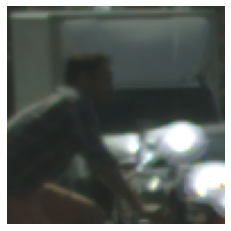

In [6]:
print(cars_array.shape)
plt.axis("off")
plt.imshow(cars_array[np.random.randint(0,cars_array.shape[0])])

(351, 96, 96, 3)


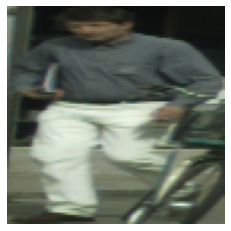

In [7]:
print(pedestrians_array.shape)
plt.axis("off")
plt.imshow(pedestrians_array[np.random.randint(0,pedestrians_array.shape[0])])

(5586, 96, 96, 3)
sky


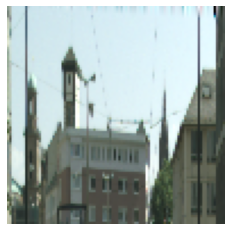

In [8]:
print(others_array.shape)
plt.axis("off")
random_index = np.random.randint(0,others_array.shape[0])
print(others_labels_array[random_index])
plt.imshow(others_array[random_index])

In [9]:
#arrays of images to training set
X_train = np.concatenate((cars_array, pedestrians_array, others_array), axis=0)
y_train = np.concatenate((np.zeros(cars_array.shape[0]), np.ones(pedestrians_array.shape[0]), np.full(others_array.shape[0],2)), axis=0)

In [10]:
from tensorflow.keras.utils import to_categorical
# to one-hot encoding
y_train = to_categorical(y_train, num_classes=3)

In [11]:
#shuffle the data
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train, random_state=0)

In [12]:
#split the data
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=0)

### Convolutive Neural Networks

In [13]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [14]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13756032606486795190
xla_global_id: -1
]


In [15]:
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.layers.advanced_activations import LeakyReLU

In [16]:
num_classes = 3

In [17]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='linear', padding='same', input_shape=(img_size,img_size,3)))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Conv2D(64, (3, 3), activation='linear', padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Flatten())
model.add(Dense(128, activation='linear'))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

In [18]:
model.compile(loss=tensorflow.keras.losses.categorical_crossentropy, optimizer=tensorflow.keras.optimizers.Adam(),metrics=['accuracy'])

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 96, 32)        896       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 96, 96, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 24, 24, 64)       0         
 2D)                                                    

In [20]:
model.fit(X_train, y_train, batch_size=32, epochs=10, verbose=1, validation_data=(X_val, y_val))

Epoch 1/10
208/208 [==============================] - 56s 256ms/step - loss: 11.8024 - accuracy: 0.7725 - val_loss: 0.4476 - val_accuracy: 0.9038
Epoch 2/10
208/208 [==============================] - 53s 256ms/step - loss: 0.5881 - accuracy: 0.8783 - val_loss: 0.9102 - val_accuracy: 0.8415
Epoch 3/10
208/208 [==============================] - 54s 259ms/step - loss: 0.3979 - accuracy: 0.9034 - val_loss: 0.3996 - val_accuracy: 0.8997
Epoch 4/10
208/208 [==============================] - 53s 253ms/step - loss: 0.2733 - accuracy: 0.9264 - val_loss: 0.4064 - val_accuracy: 0.9106
Epoch 5/10
208/208 [==============================] - 52s 252ms/step - loss: 0.2155 - accuracy: 0.9403 - val_loss: 0.3834 - val_accuracy: 0.9228
Epoch 6/10
208/208 [==============================] - 53s 253ms/step - loss: 0.1969 - accuracy: 0.9490 - val_loss: 0.4736 - val_accuracy: 0.9146
Epoch 7/10
208/208 [==============================] - 52s 251ms/step - loss: 0.1660 - accuracy: 0.9576 - val_loss: 0.4596 - val_a

Text(0.5, 0, 'epoch')

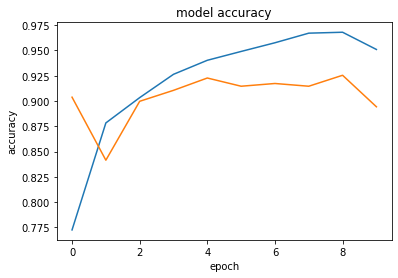

In [21]:
#graph accuracy vs val_accuracy
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')